In [26]:
## IMPORT LIBRARIES AND FILE
import matplotlib.pyplot as plt
from scipy.stats import kstest
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                            recall_score, precision_score, confusion_matrix, classification_report)
from matplotlib.patches import Patch
from scipy.stats import spearmanr, kruskal, chi2_contingency, fisher_exact
from statsmodels.graphics.mosaicplot import mosaic

file_path = "/home/phd2/Scrivania/CorsoRepo/colposcopy_sara/Colposcopy/datasets/dati_puliti.xlsx"
file = pd.read_excel(file_path)

# Age Analysis

In [ ]:
def analisi_eta(file):
    file['ETA'] = file['ETA  (anni)'].astype(float)
    file['ETA'] = file['ETA'].dropna()

    # calcolo età media persona sottoposta a colposcopia
    eta_mean = file['ETA'].mean()
    print('Età media donne sottoposte a colposcopia:', eta_mean, "\n")

    # Pulizia colonne
    file['ENDO_CLEAN'] = file['ESITO_ISTOLOGICO ENDO (NEG, G1, SE >= CIN2 == G2)'].astype(str).str.strip().str.upper()
    file['ESO_CLEAN'] = file['ESITO BIOPSIA ESO (NEG, G1, G2 SE >=CIN2)'].astype(str).str.strip().str.upper()


    #----------Distribuzione in età----------------
    # guardo la distribuzione in età

    pazienti_minus25 = sum(file['ETA'] <= 25)
    print("Numero di pazienti con età minore di 25:", pazienti_minus25, "\n")

    pazienti_25_50 = sum((file['ETA'] > 25) & (file['ETA'] <= 50))
    print("Numero di pazienti con età tra i 25 e 50:", pazienti_25_50, "\n")

    pazienti_mas50 = sum(file['ETA'] > 50)
    print("Numero di pazienti con età maggiore di 50:", pazienti_mas50, "\n")

    # stampo le colonne
    #print(file.columns)

    # ----------------------test statistico per studiare la distibuzione dell'età e vedere se è bimodale---------
    eta = file['ETA'].dropna()

    #Normalizziamo i dati per il test KS:
    # dobbiamo confrontare i dati con una distribuzione normale standard (media=0, std=1)
    eta_norm = (eta - np.mean(eta)) / np.std(eta)

    # Kolmogorov–Smirnov test
    stat, p = kstest(eta_norm, "norm")
    print(f"Kolmogorov–Smirnov test: statistic={stat:.4f}, p-value={p:.6f}")

    if p > 0.05:
        print("I dati sono compatibili con una distribuzione normale (non rifiuto H0).")
    else:
        print("I dati NON seguono una distribuzione normale (rifiuto H0).")


    #guardo se i dati sono bimodali
   
    # ---  Calcolo KDE ---
    x = np.linspace(min(eta), max(eta), 500)
    kde = gaussian_kde(eta)
    y = kde(x)

    X = eta.values.reshape(-1, 1)

    # --- K-MEANS CLUSTERING ---
    kmeans = KMeans(n_clusters=2, random_state=0)
    labels = kmeans.fit_predict(X)
    centroids = np.sort(kmeans.cluster_centers_.flatten())

    # --- COSTRUZIONE DATAFRAME PER GRAFICO ---
    df_clusters = pd.DataFrame({'Età': eta, 'Cluster': labels})

    # Ordina i cluster in base alla media (0=giovani, 1=anziane)
    cluster_order = df_clusters.groupby('Cluster')['Età'].mean().sort_values().index
    df_clusters['Cluster'] = df_clusters['Cluster'].replace({
        cluster_order[0]: 'Cluster 1 ',
        cluster_order[1]: 'Cluster 2 '
    })

    # --- VISUALIZZAZIONE ---
    plt.figure(figsize=(10,6))

    colors = ['#69b3a2', '#ff9999']

    for i, (cluster, color) in enumerate(zip(df_clusters['Cluster'].unique(), colors)):
        subset = df_clusters[df_clusters['Cluster'] == cluster]['Età']
        
        # KDE (curva di densità) per ogni cluster
        kde = gaussian_kde(subset)
        x_vals = np.linspace(min(eta), max(eta), 200)
        plt.plot(x_vals, kde(x_vals), color=color, lw=2,
                label=f"{cluster} (media = {subset.mean():.1f})")
        
        # Istogramma parziale
        plt.hist(subset, bins=20, density=True, color=color,
                alpha=0.3, edgecolor='black')

    plt.xlabel("Età")
    plt.ylabel("Densità")
    plt.title("Distribuzione dell'età per cluster (K-Means)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- INFO CLUSTER ---
    for c in df_clusters['Cluster'].unique():
        n = len(df_clusters[df_clusters['Cluster'] == c])
        mean_age = df_clusters[df_clusters['Cluster'] == c]['Età'].mean()
        print(f"{c}: {n} pazienti, età media = {mean_age:.1f} anni")

    print(f"\nCentroidi K-Means (età): {centroids}")

Età media donne sottoposte a colposcopia: 41.129129129129126 

Numero di pazienti con età minore di 25: 20 

Numero di pazienti con età tra i 25 e 50: 235 

Numero di pazienti con età maggiore di 50: 78 

Kolmogorov–Smirnov test: statistic=0.1222, p-value=0.000086
I dati NON seguono una distribuzione normale (rifiuto H0).


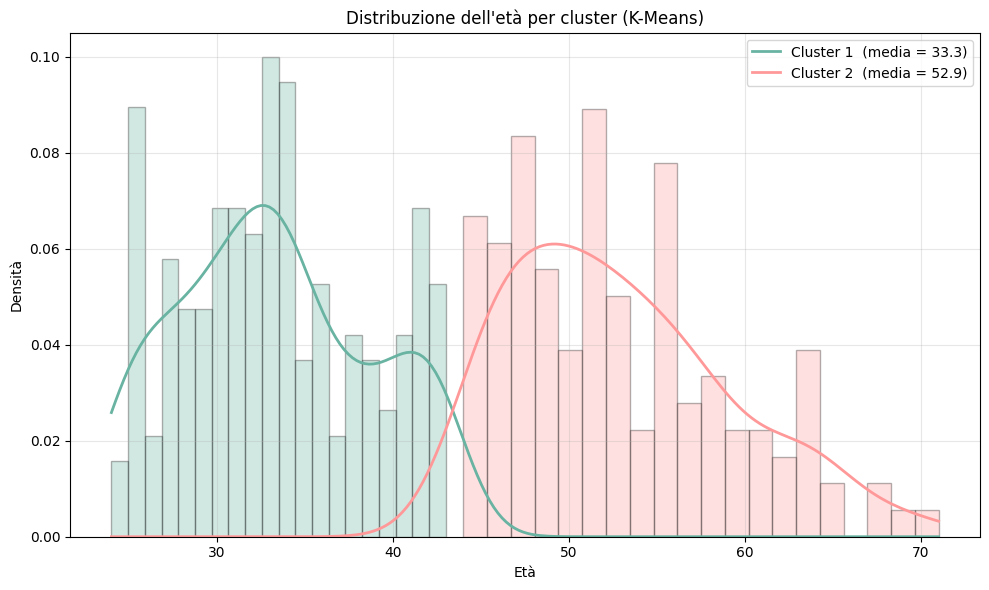

Cluster 1 : 200 pazienti, età media = 33.3 anni
Cluster 2 : 133 pazienti, età media = 52.9 anni

Centroidi K-Means (età): [33.305      52.89473684]


In [ ]:
analisi_eta(file)

# Graphs

In [15]:
#----------------------FUNZIONE PER I GRAFICI-----------------------
def graphics(file):
    #------Grafico età------
    file['ETA'] = file['ETA  (anni)'].astype(float)

#-------------------GRAFICI ETA'- TIPO LESIONE-----------------------
    plt.figure(figsize=(8,5))
    plt.hist(
    [file[file['ESITO FINALE'] == esito]['ETA'] for esito in file['ESITO FINALE'].unique()],
    bins=5,
    label=file['ESITO FINALE'].unique(),
    alpha=0.7
)

    plt.xlabel("Età")
    plt.ylabel("Frequenza")
    plt.title("Distribuzione dell'Età per Esito Finale")
    plt.legend(title="Esito finale")
    plt.grid(alpha=0.3)
    plt.show()

#----------------------CALCOLO PROPORIZIONI E GRAFICO A TORTA--------------------------
    endo = 'ESITO_ISTOLOGICO ENDO (NEG, G1, SE >= CIN2 == G2)'
    eso = 'ESITO BIOPSIA ESO (NEG, G1, G2 SE >=CIN2)'

# Conta G1, G2,G3 e NEG (almeno uno tra endo o eso--> prendo la colonna "ESITO FINALE" in cui è stata fatto una selezione tra i dati)
    count_G1 = (file['ESITO FINALE']=='G1').sum()
    count_G2 = (file['ESITO FINALE']=='G2').sum() 
    count_NEG = ((file['ESITO FINALE'].isin(['NEG']))).sum()

    print("Percentuale di pazienti con almeno un esito negativo (ENDO o ESO):", count_NEG / len(file['ESITO FINALE']))
    print("Percentuale di pazienti con almeno un esito G1 (ENDO o ESO):", count_G1 / len(file['ESITO FINALE']))
    print("Percentuale di pazienti con almeno un esito G2 (ENDO o ESO):", count_G2 / len(file['ESITO FINALE']))
    print("somma percentuali:", (count_G1+count_G2+count_NEG)/len(file['ESITO FINALE']))

    # Grafico a torta
    labels = ['G1', 'G2', 'NEG']
    sizes = [count_G1, count_G2, count_NEG]
    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['orange', 'red', 'green'])
    plt.title('Distribuzione delle classi (G1, G2, NEG)')
    plt.axis('equal')  # Per avere una torta circolare
    plt.show()

# -----------------------SCATTER PLOT ETA/ESITO------------------
    # Scatter plot tra eta e esito
    # Mapping esito -> numero

    mapping = {'NEG': 0, 'G1': 1, 'G2': 2}
    file['esito_cod'] = file['ESITO FINALE'].map(mapping)

    # Tolgo eventuali righe con il Nan
    file_pul = file.dropna(subset=['ETA', 'esito_cod'])

    # Mappa colori--> divido in base alla gravità
    color_map = {0: 'green', 1: 'orange', 2: 'red'}
    colors = file_pul['esito_cod'].map(color_map)

    # Crea scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(file_pul['ETA'], file_pul['esito_cod'], c=colors, edgecolor='black', alpha=0.7)

    # Etichette asse
    plt.xlabel('Età (anni)', fontsize=12)
    plt.ylabel('Grado della Lesione', fontsize=12)
    plt.title('Età vs Grado della Lesione', fontsize=14)

    # Etichette personalizzate per asse Y
    plt.yticks([0, 1, 2], ['NEG', 'G1', 'G2'])

    # Legenda manuale per i colori
    legend_elements = [
        Patch(facecolor='green', label='NEG'),
        Patch(facecolor='orange', label='G1'),
        Patch(facecolor='red', label='G2'),
        
    ]
    plt.legend(handles=legend_elements, title='Esito finale', loc='upper right')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

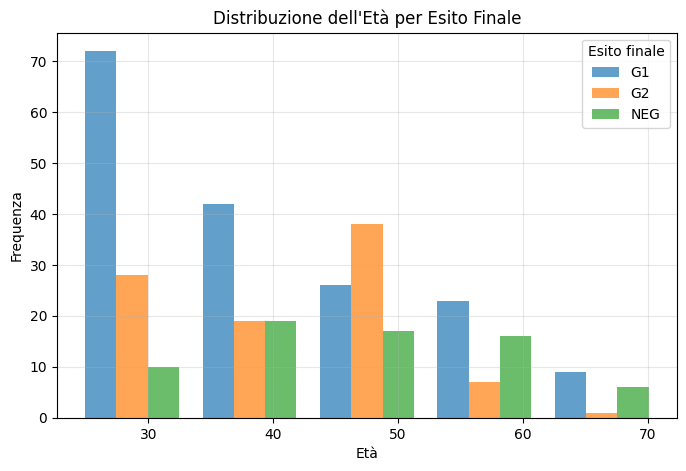

Percentuale di pazienti con almeno un esito negativo (ENDO o ESO): 0.20238095238095238
Percentuale di pazienti con almeno un esito G1 (ENDO o ESO): 0.5208333333333334
Percentuale di pazienti con almeno un esito G2 (ENDO o ESO): 0.2767857142857143
somma percentuali: 1.0


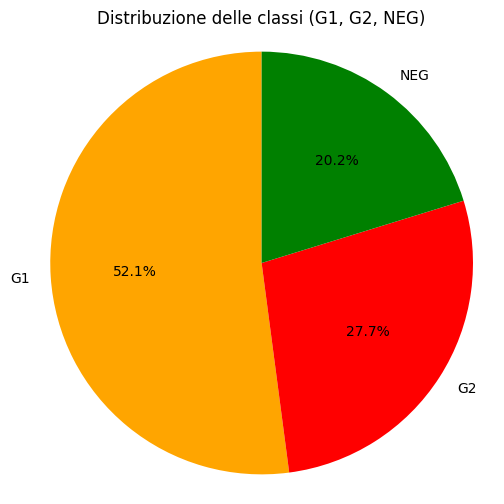

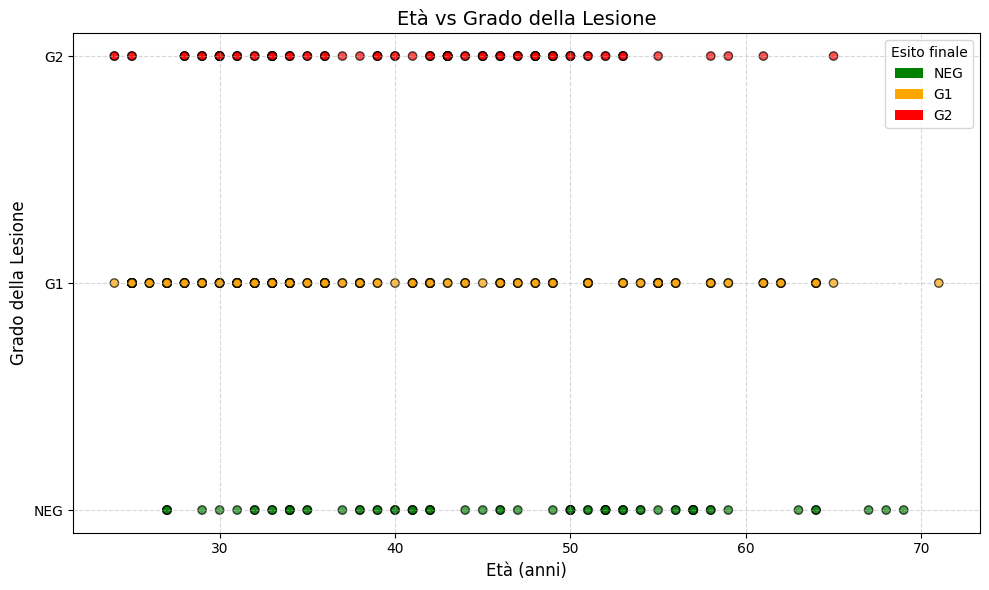

In [18]:
graphics(file)

# Correlation

In [30]:
#-------------------------CORRELAZIONI TRA VARIABILI---------------------------

def corr(file):
    # === PULIZIA BASE ===
    def pulisci(col):
        return (col.astype(str)
                .str.strip()
                .str.upper()
                .replace({'NAN': np.nan, '': np.nan}))

    file = file.copy()
    for col in file.columns:
        if file[col].dtype == 'object':
            file[col] = pulisci(file[col])

    # === MAPPATURA BINARIA (SI/NO → 1/0) ===
    for col in file.columns:
        if file[col].dropna().isin(['SI', 'NO']).all():
            file[col + '_NUM'] = file[col].map({'SI': 1, 'NO': 0})

    # === CODIFICA DELL’ESITO ===
    mapping = {'NEG': 0, 'G1': 1, 'G2': 2}
    if 'ESITO FINALE' not in file.columns:
        raise ValueError("Colonna 'ESITO FINALE' non trovata nel file.")
    file['ESITO_NUM'] = file['ESITO FINALE'].map(mapping)

    # === SELEZIONE VARIABILI NUMERICHE DA ANALIZZARE ===
    num_cols = [c for c in file.columns if c != 'ESITO_NUM' and file[c].dtype != 'object']

    print("\n=== ANALISI RISPETTO A: ESITO FINALE ===\n")

    # === LOOP SU TUTTE LE COLONNE NUMERICHE ===
    for col in num_cols:
        file_cleaned = file.dropna(subset=[col, 'ESITO_NUM'])
        if len(file_cleaned) < 5:
            continue

        # Test di correlazione Spearman
        r, p = spearmanr(file_cleaned[col], file_cleaned['ESITO_NUM'])
        print(f"{col} → Spearman r={r:.2f}, p={p:.4f}")

        # === Caso 1: Variabile numerica continua ===
        if p < 0.05 and not file[col].dropna().isin([0, 1]).all():
            gruppi = [g[col].values for _, g in file_cleaned.groupby("ESITO_NUM")]
            H, pk = kruskal(*gruppi)
            print(f"  → Kruskal–Wallis: H={H:.3f}, p={pk:.4f}")

            plt.figure(figsize=(6,4))
            sns.boxplot(x='ESITO_NUM', y=col, data=file_cleaned, color='lightblue')
            plt.title(f"{col} vs Esito finale (p={pk:.4f})")
            plt.xlabel("Esito finale (0=NEG, 1=G1, 2=G2)")
            plt.ylabel(col)

            # Pulizia nome file per evitare errori
            safe_col = "".join(c if c.isalnum() or c in "_-" else "_" for c in col)
            plt.show()

        # === Caso 2: Variabile binaria (0/1) → test di indipendenza ===
        elif file[col].dropna().isin([0, 1]).all():
            cont = pd.crosstab(file[col], file['ESITO_NUM'])
            if cont.values.min() < 5:
                _, pf = fisher_exact(cont)
                print(f"  → Fisher exact test: p={pf:.4f}")
                test_name = "Fisher"
                p_to_show = pf
            else:
                chi2, pc, _, _ = chi2_contingency(cont)
                print(f"  → Chi-quadro: χ²={chi2:.3f}, p={pc:.4f}")
                test_name = "Chi2"
                p_to_show = pc

            plt.figure(figsize=(5,5))
            mosaic(cont.stack())
            plt.title(f"{col} vs Esito finale ({test_name}, p={p_to_show:.4f})")

            # Pulizia nome file per evitare errori
            safe_col = "".join(c if c.isalnum() or c in "_-" else "_" for c in col)
            plt.show()

    print("\nAnalisi completata ✅")


=== ANALISI RISPETTO A: ESITO FINALE ===

Educational qualification → Spearman r=-0.05, p=0.5526
ETA  (anni) → Spearman r=-0.13, p=0.0187
  → Kruskal–Wallis: H=21.065, p=0.0000


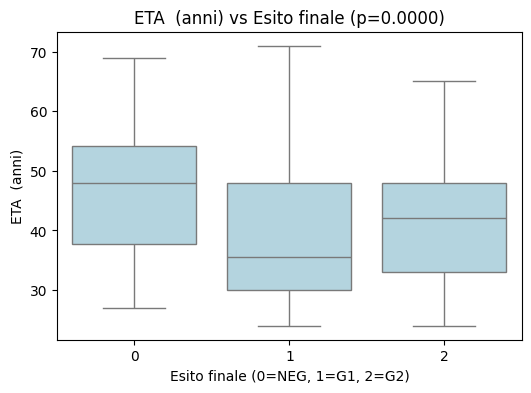

Menopausal status_NUM → Spearman r=-0.21, p=0.0001
  → Chi-quadro: χ²=17.826, p=0.0001


<Figure size 500x500 with 0 Axes>

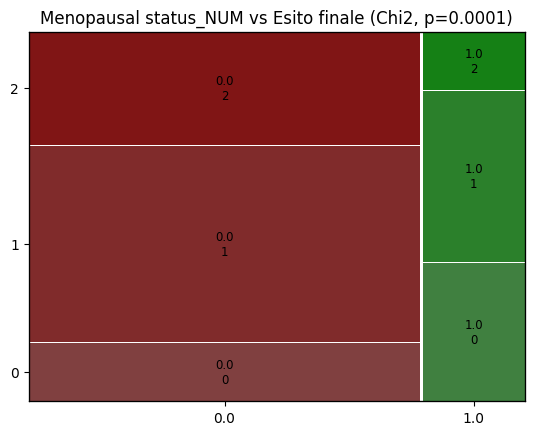

Smoke_NUM → Spearman r=0.06, p=0.3499
  → Chi-quadro: χ²=0.905, p=0.6359


<Figure size 500x500 with 0 Axes>

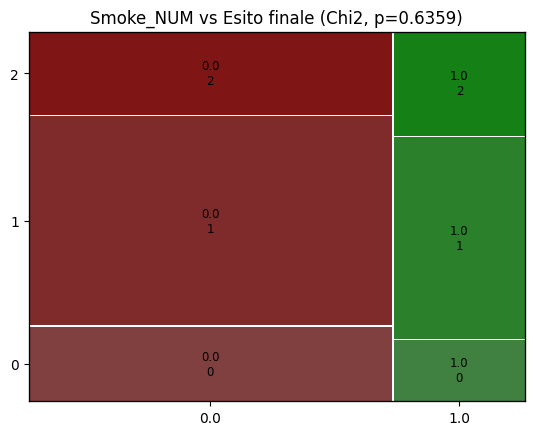

HPV vaccination_NUM → Spearman r=-0.01, p=0.8829
  → Chi-quadro: χ²=6.778, p=0.0337


<Figure size 500x500 with 0 Axes>

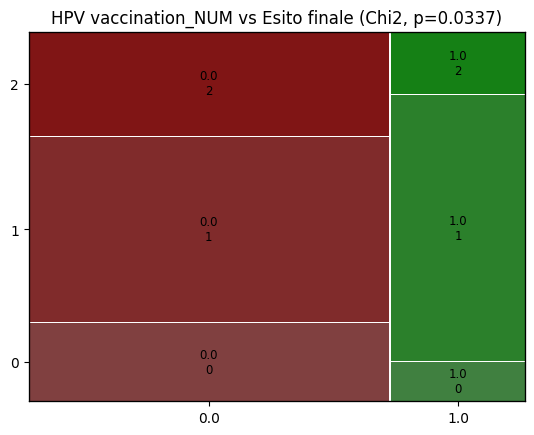

HPV_PASSIVITA  (SI/NO)_NUM → Spearman r=0.11, p=0.0422
  → Chi-quadro: χ²=5.795, p=0.0552


<Figure size 500x500 with 0 Axes>

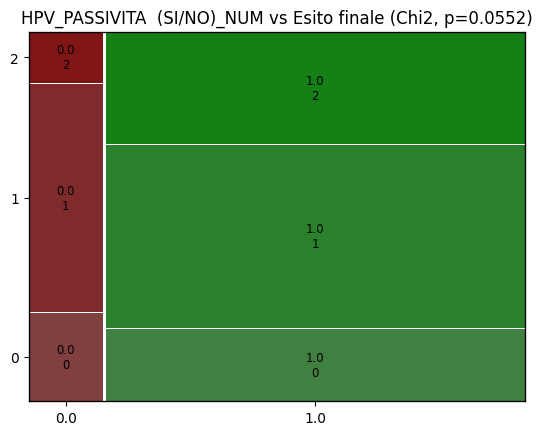

BIOPSIA ENDO SI/NO_NUM → Spearman r=-0.21, p=0.0002
  → Chi-quadro: χ²=44.827, p=0.0000


<Figure size 500x500 with 0 Axes>

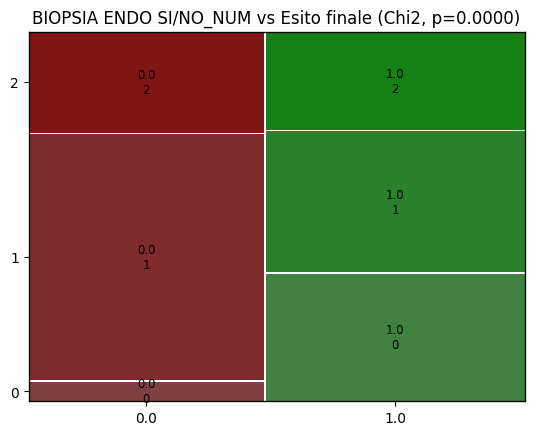


Analisi completata ✅


In [31]:
corr(file)

# Colposcopists Performance

Numero righe valide per il confronto: 323 su 336 totali

Accuracy semplice: 0.666
Balanced Accuracy: 0.624
Recall (macro): 0.624
Precision (macro): 0.693

Matrice di confusione:
[[ 43  19   1]
 [ 26 138   5]
 [  8  49  34]]

 Report di classificazione:
              precision    recall  f1-score   support

         NEG       0.56      0.68      0.61        63
          G1       0.67      0.82      0.74       169
          G2       0.85      0.37      0.52        91

    accuracy                           0.67       323
   macro avg       0.69      0.62      0.62       323
weighted avg       0.70      0.67      0.65       323



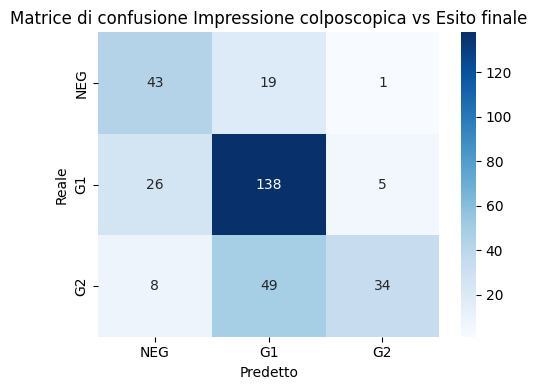

In [12]:
#-------------------------METRICHE------------------
# Mappa i valori 
mapping = {'NEG': 0, 'G1': 1, 'G2': 2}

# Applica la mappatura
file_cleaned = file.dropna(subset=['IMPRESSIONE_COLPOSCOPICA_FINALE', 'ESITO FINALE']).copy()
file_cleaned['ESITO_NUM'] = file_cleaned['ESITO FINALE'].map(mapping)
file_cleaned['IMP_NUM'] = file_cleaned['IMPRESSIONE_COLPOSCOPICA_FINALE'].map(mapping)

# Rimuove righe dove la mappatura ha prodotto NaN 
file_eval = file_cleaned.dropna(subset=['ESITO_NUM', 'IMP_NUM']).copy()

print(f"Numero righe valide per il confronto: {len(file_eval)} su {len(file)} totali\n")

# Estrai y_true e y_pred puliti
y_true = file_eval['ESITO_NUM']
y_pred = file_eval['IMP_NUM']

# === METRICHE ===
acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, average='macro')
prec = precision_score(y_true, y_pred, average='macro')

print(f"Accuracy semplice: {acc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")
print(f"Recall (macro): {rec:.3f}")
print(f"Precision (macro): {prec:.3f}\n")

# === MATRICE DI CONFUSIONE ===
cm = confusion_matrix(y_true, y_pred)
print("Matrice di confusione:")
print(cm)

# ======= REPORT  ========
print("\n Report di classificazione:")
print(classification_report(y_true, y_pred, target_names=['NEG', 'G1', 'G2']))

# === HEATMAP ===
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NEG', 'G1', 'G2'],
            yticklabels=['NEG', 'G1', 'G2'])

plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di confusione Impressione colposcopica vs Esito finale")
plt.tight_layout()
plt.show()